In [1]:
import torch

import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.preprocessing import MinMaxScaler
from pandas.plotting import register_matplotlib_converters
from torch import nn, optim

In [2]:
rcParams['figure.figsize'] = 14, 10
register_matplotlib_converters()

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

In [3]:
df = pd.read_csv('https://api.covid19india.org/csv/latest/state_wise_daily.csv')
df

,Date,Status,TT,AN,AP,AR,AS,BR,CH,CT,...,PB,RJ,SK,TN,TG,TR,UP,UT,WB,UN
0,14-Mar-20,Confirmed,81,0,1,0,0,0,0,0,...,1,3,0,1,1,0,12,0,0,0
1,14-Mar-20,Recovered,9,0,0,0,0,0,0,0,...,0,1,0,0,0,0,4,0,0,0
2,14-Mar-20,Deceased,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,15-Mar-20,Confirmed,27,0,0,0,0,0,0,0,...,0,1,0,0,2,0,1,0,0,0
4,15-Mar-20,Recovered,4,0,0,0,0,0,0,0,...,0,2,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
370,15-Jul-20,Recovered,20646,1,911,0,715,514,13,49,...,204,333,1,5000,1159,66,762,81,749,0
371,15-Jul-20,Deceased,614,0,44,0,2,14,1,0,...,8,6,0,68,11,1,29,0,20,0
372,16-Jul-20,Confirmed,35468,4,2593,52,892,1385,16,198,...,295,737,13,4549,1676,98,2058,197,1690,-239
373,16-Jul-20,Recovered,22867,3,1015,0,666,568,17,127,...,410,468,0,5106,1296,33,932,47,735,0


In [4]:
confirmed_df = df[df.Status == "Confirmed"]
confirmed_df = confirmed_df.reset_index(drop = True)
confirmed_df

,Date,Status,TT,AN,AP,AR,AS,BR,CH,CT,...,PB,RJ,SK,TN,TG,TR,UP,UT,WB,UN
0,14-Mar-20,Confirmed,81,0,1,0,0,0,0,0,...,1,3,0,1,1,0,12,0,0,0
1,15-Mar-20,Confirmed,27,0,0,0,0,0,0,0,...,0,1,0,0,2,0,1,0,0,0
2,16-Mar-20,Confirmed,15,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
3,17-Mar-20,Confirmed,11,0,0,0,0,0,0,0,...,0,0,0,0,1,0,2,0,1,0
4,18-Mar-20,Confirmed,37,0,0,0,0,0,0,0,...,1,3,0,1,8,0,2,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120,12-Jul-20,Confirmed,29106,7,1933,19,735,1266,10,184,...,234,644,4,4244,1269,105,1384,120,1560,-392
121,13-Jul-20,Confirmed,28178,3,1935,27,1001,1116,29,184,...,357,544,2,4328,1550,26,1654,71,1435,-666
122,14-Jul-20,Confirmed,29917,5,1916,75,859,1432,12,114,...,333,635,45,4526,1524,90,1594,78,1390,-179
123,15-Jul-20,Confirmed,32607,5,2432,29,1088,1320,19,177,...,288,866,11,4496,1597,98,1659,99,1589,-655


In [5]:
recovered_df = df[df.Status == "Recovered"]
deceased_df = df[df.Status == "Deceased"]

In [6]:
confirmed_df = confirmed_df.drop("Status", axis = 1)


In [7]:
daily_conf_cases = confirmed_df.iloc[0:,1]
daily_conf_cases.index = pd.to_datetime(confirmed_df['Date'])
daily_conf_cases.head()


Date
2020-03-14    81
2020-03-15    27
2020-03-16    15
2020-03-17    11
2020-03-18    37
Name: TT, dtype: int64

(125,)

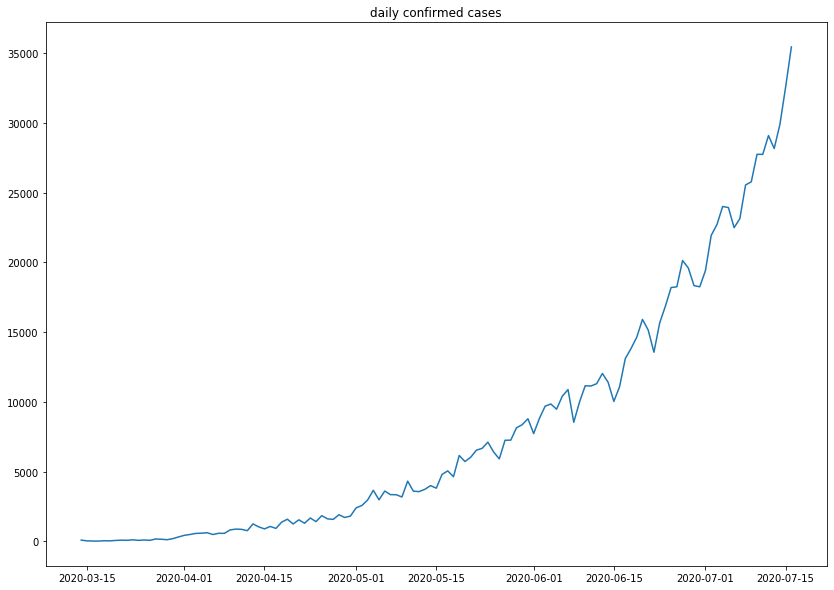

In [8]:
plt.plot(daily_conf_cases)
plt.title("daily confirmed cases");
daily_conf_cases.shape

In [9]:
test_data_size = 40

train_data = daily_conf_cases[:-test_data_size]
test_data = daily_conf_cases[-test_data_size:]
print(train_data.shape)
print(test_data.shape)

(85,)
(40,)


In [10]:
scaler = MinMaxScaler()
scaler = scaler.fit(train_data[:, np.newaxis])
train_data = scaler.transform(train_data[:, np.newaxis])
test_data = scaler.transform(test_data[:, np.newaxis])
print(train_data[:5])
print(test_data[:5])

[[0.00673271]
 [0.00153891]
 [0.00038473]
 [0.        ]
 [0.00250072]]
[[1.04559007]
 [0.81994806]
 [0.95893046]
 [1.07194383]
 [1.06992402]]


In [11]:
def create_seq(data, seq_len):
    x = []
    y = []
    for i in range(len(data)-seq_len-1):
        x1 = data[i:(i+seq_len)]
        y1 = data[i+seq_len]
        x.append(x1)
        y.append(y1)
    return np.array(x), np.array(y)

In [12]:
seq_len = 5
xtrain, ytrain = create_seq(train_data, seq_len)
xtest, ytest = create_seq(test_data, seq_len)
xtrain = torch.from_numpy(xtrain).float()
ytrain = torch.from_numpy(ytrain).float()
xtest = torch.from_numpy(xtest).float()
ytest = torch.from_numpy(ytest).float()

In [13]:
print(xtrain.shape)
print(xtrain[:2])

torch.Size([79, 5, 1])
tensor([[[0.0067],
         [0.0015],
         [0.0004],
         [0.0000],
         [0.0025]],

        [[0.0015],
         [0.0004],
         [0.0000],
         [0.0025],
         [0.0015]]])


In [14]:
print(ytrain.shape)
print(ytrain[:2])

torch.Size([79, 1])
tensor([[0.0015],
        [0.0045]])


In [15]:
train_data[:10]

array([[0.00673271],
       [0.00153891],
       [0.00038473],
       [0.        ],
       [0.00250072],
       [0.00153891],
       [0.00452053],
       [0.00644417],
       [0.00538617],
       [0.00875252]])

In [16]:
class CoronaVirusPredictor(nn.Module):

  def __init__(self, n_features, n_hidden, seq_len, n_layers=2):
    super(CoronaVirusPredictor, self).__init__()

    self.n_hidden = n_hidden
    self.seq_len = seq_len
    self.n_layers = n_layers

    self.lstm = nn.LSTM(
      input_size=n_features,
      hidden_size=n_hidden,
      num_layers=n_layers,
      dropout=0.5
    )

    self.linear = nn.Linear(in_features=n_hidden, out_features=1)

  def reset_hidden_state(self):
    self.hidden = (
        torch.zeros(self.n_layers, self.seq_len, self.n_hidden),
        torch.zeros(self.n_layers, self.seq_len, self.n_hidden)
    )

  def forward(self, sequences):
    lstm_out, self.hidden = self.lstm(
      sequences.view(len(sequences), self.seq_len, -1),
      self.hidden
    )
    last_time_step = \
      lstm_out.view(self.seq_len, len(sequences), self.n_hidden)[-1]
    y_pred = self.linear(last_time_step)
    return y_pred

In [17]:
def train_model(
  model, 
  train_data, 
  train_labels, 
  test_data=None, 
  test_labels=None
):
  loss_fn = torch.nn.MSELoss(reduction='sum')

  optimiser = torch.optim.Adam(model.parameters(), lr=1e-3)
  num_epochs = 100

  train_hist = np.zeros(num_epochs)
  test_hist = np.zeros(num_epochs)

  for t in range(num_epochs):
    model.reset_hidden_state()

    y_pred = model(xtrain)

    loss = loss_fn(y_pred.float(), ytrain)

    if test_data is not None:
      with torch.no_grad():
        y_test_pred = model(xtest)
        test_loss = loss_fn(y_test_pred.float(), ytest)
      test_hist[t] = test_loss.item()

      if t % 10 == 0:  
        print(f'Epoch {t} train loss: {loss.item()} test loss: {test_loss.item()}')
    elif t % 10 == 0:
      print(f'Epoch {t} train loss: {loss.item()}')

    train_hist[t] = loss.item()
    
    optimiser.zero_grad()

    loss.backward()

    optimiser.step()
  
  return model.eval(), train_hist, test_hist

In [18]:
model = CoronaVirusPredictor(
  n_features=1, 
  n_hidden=512, 
  seq_len=seq_len, 
  n_layers=3
)
model, train_hist, test_hist = train_model(
  model, 
  xtrain, 
  ytrain, 
  xtest, 
  ytest
)

Epoch 0 train loss: 14.034821510314941 test loss: 138.98544311523438
Epoch 10 train loss: 5.824552536010742 test loss: 74.20782470703125
Epoch 20 train loss: 13.092329978942871 test loss: 12.75053882598877
Epoch 30 train loss: 5.790828227996826 test loss: 72.99739837646484
Epoch 40 train loss: 4.383436679840088 test loss: 18.87255096435547
Epoch 50 train loss: 5.826416015625 test loss: 9.070825576782227
Epoch 60 train loss: 4.145559310913086 test loss: 10.161130905151367
Epoch 70 train loss: 2.520653009414673 test loss: 14.108470916748047
Epoch 80 train loss: 1.3911112546920776 test loss: 75.99208068847656
Epoch 90 train loss: 0.936664342880249 test loss: 88.00878143310547


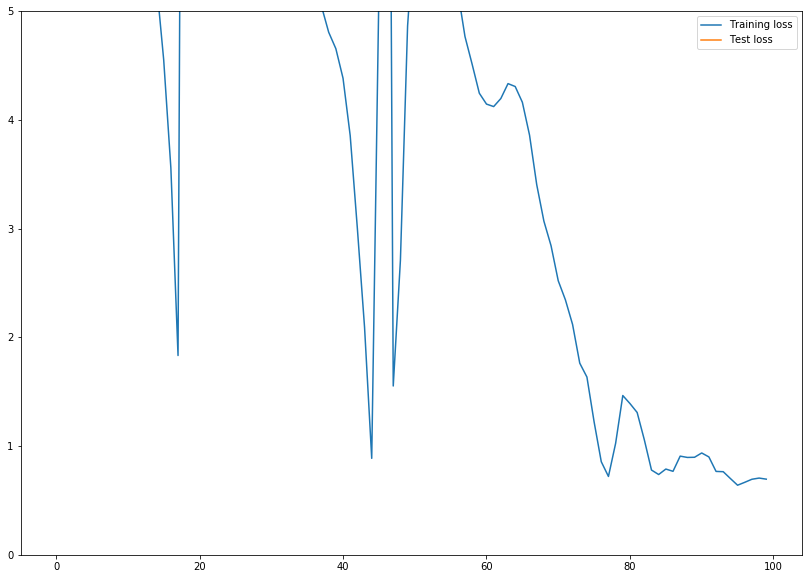

In [19]:
plt.plot(train_hist, label="Training loss")
plt.plot(test_hist, label="Test loss")
plt.ylim((0, 5))
plt.legend();

In [20]:
with torch.no_grad():
  test_seq = xtest[:1]
  preds = []
  for _ in range(len(xtest)):
    y_test_pred = model(test_seq)
    pred = torch.flatten(y_test_pred).item()
    preds.append(pred)
    new_seq = test_seq.numpy().flatten()
    new_seq = np.append(new_seq, [pred])
    new_seq = new_seq[1:]
    test_seq = torch.as_tensor(new_seq).view(1, seq_len, 1).float()

In [21]:
true_cases = scaler.inverse_transform(
    np.expand_dims(ytest.flatten().numpy(), axis=0)
).flatten()

predicted_cases = scaler.inverse_transform(
  np.expand_dims(preds, axis=0)
).flatten()

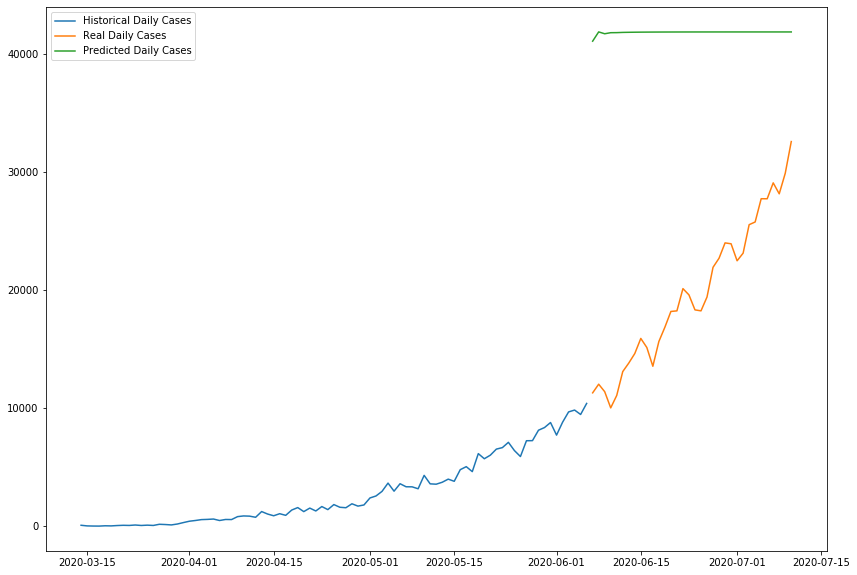

In [22]:
plt.plot(
  daily_conf_cases.index[:len(train_data)], 
  scaler.inverse_transform(train_data).flatten(),
  label='Historical Daily Cases'
)

plt.plot(
  daily_conf_cases.index[len(train_data):len(train_data) + len(true_cases)], 
  true_cases,
  label='Real Daily Cases'
)

plt.plot(
  daily_conf_cases.index[len(train_data):len(train_data) + len(true_cases)], 
  predicted_cases, 
  label='Predicted Daily Cases'
)

plt.legend();

In [23]:
scaler = MinMaxScaler()

scaler = scaler.fit(np.expand_dims(daily_conf_cases, axis=1))

all_data = scaler.transform(np.expand_dims(daily_conf_cases, axis=1))

all_data.shape

(125, 1)

In [24]:
X_all, y_all = create_seq(all_data, seq_len)

X_all = torch.from_numpy(X_all).float()
y_all = torch.from_numpy(y_all).float()

model = CoronaVirusPredictor(
  n_features=1, 
  n_hidden=512, 
  seq_len=seq_len, 
  n_layers=2
)
model, train_hist, _ = train_model(model, X_all, y_all)

Epoch 0 train loss: 11.775445938110352
Epoch 10 train loss: 5.32081413269043
Epoch 20 train loss: 7.273715972900391
Epoch 30 train loss: 6.518981456756592
Epoch 40 train loss: 6.23726224899292
Epoch 50 train loss: 5.870824337005615
Epoch 60 train loss: 5.570752143859863
Epoch 70 train loss: 3.560953140258789
Epoch 80 train loss: 12.73415470123291
Epoch 90 train loss: 7.303014755249023


In [25]:
DAYS_TO_PREDICT = 35
with torch.no_grad():
  test_seq = X_all[:1]
  preds = []
  for _ in range(DAYS_TO_PREDICT):
    y_test_pred = model(test_seq)
    pred = torch.flatten(y_test_pred).item()
    preds.append(pred)
    new_seq = test_seq.numpy().flatten()
    new_seq = np.append(new_seq, [pred])
    new_seq = new_seq[1:]
    test_seq = torch.as_tensor(new_seq).view(1, seq_len, 1).float()

In [39]:
predicted_cases = scaler.inverse_transform(
  np.expand_dims(preds, axis=0)
).flatten()

In [40]:
daily_conf_cases.index[-1]

Timestamp('2020-07-04 00:00:00')

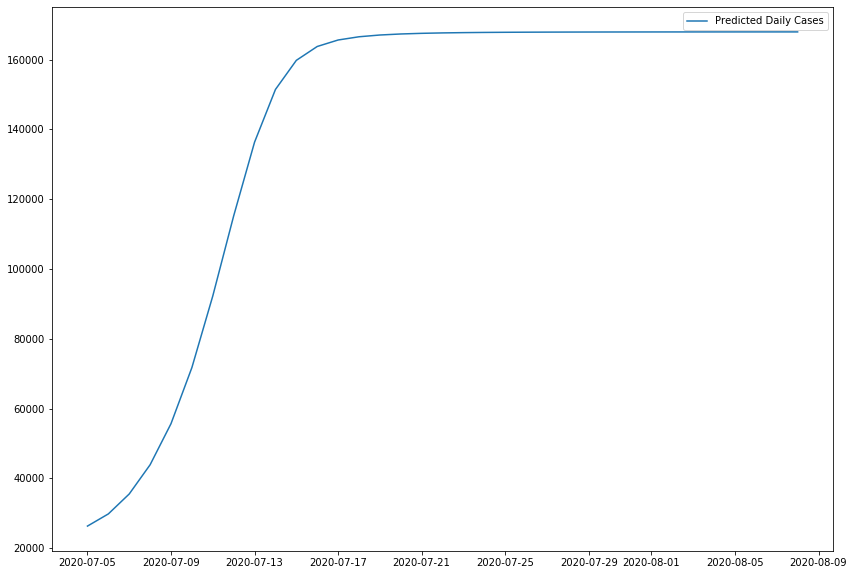

In [41]:
predicted_index = pd.date_range(
  start=daily_conf_cases.index[-1],
  periods=DAYS_TO_PREDICT + 1,
  closed='right'
)

predicted_cases = pd.Series(
  data=predicted_cases,
  index=predicted_index
)

plt.plot(predicted_cases, label='Predicted Daily Cases')
plt.legend();

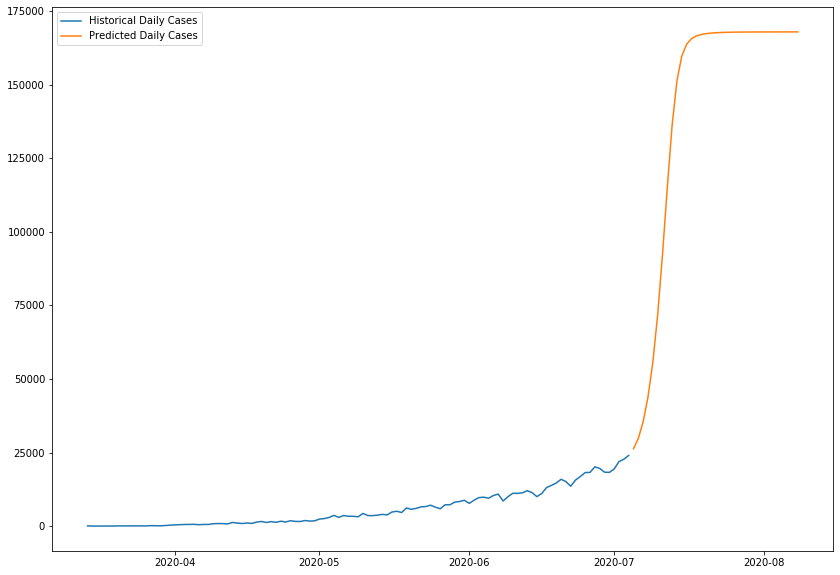

In [42]:
plt.plot(daily_conf_cases, label='Historical Daily Cases')
plt.plot(predicted_cases, label='Predicted Daily Cases')
plt.legend();